# Configuration and Exploratory Analysis of the SPLINK Model

This notebook contains the configuration and exploratory analysis for using the [SPLINK](https://moj-analytical-services.github.io/splink/index.html) model to run a record linkage algorithm.
The goal is to execute this model after receiving results from [OpenSearch](https://opensearch.org/).

In general, the idea is to perform the following steps when someone queries the `GET /v1/production-locations/` endpoint with the name and address of the production location:

1. First, query the OpenSearch cluster's `production-locations` index using [hybrid search](https://opensearch.org/docs/latest/vector-search/ai-search/hybrid-search/index/).

2. After obtaining the search results, use the [real-time record linkage](https://moj-analytical-services.github.io/splink/demos/examples/duckdb/real_time_record_linkage.html) capability of the SPLINK library to generate confidence scores for potential matches.


In [43]:
# add default imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Exploratory data analysis

### 1. Load the data from csv

In [ ]:
locs_df = pd.read_csv("production_locations_ds.csv")
locs_df = locs_df.drop(columns=[
    "created_at",
    "updated_at",
    "potential_match_score",
    "potential_match_os_id",
    "found_index"
])
locs_df["geo_hash_4"] = locs_df["geo_hash"].str.slice(0, 4)
locs_df["geo_hash_5"] = locs_df["geo_hash"].str.slice(0, 5)

### 2. Print data frame info

In [45]:
locs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118341 entries, 0 to 1118340
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   os_id                   1118341 non-null  object 
 1   name                    1118341 non-null  object 
 2   address                 1118339 non-null  object 
 3   lat                     1118341 non-null  float64
 4   lng                     1118341 non-null  float64
 5   geo_hash                1118341 non-null  object 
 6   country_code            1118331 non-null  object 
 7   found_score             1118341 non-null  float64
 8   geocoded_location_type  1027110 non-null  object 
 9   geocoded_address        1027110 non-null  object 
 10  geo_hash_4              1118341 non-null  object 
 11  geo_hash_5              1118341 non-null  object 
dtypes: float64(3), object(9)
memory usage: 102.4+ MB


### 3. Plot top countries and location types

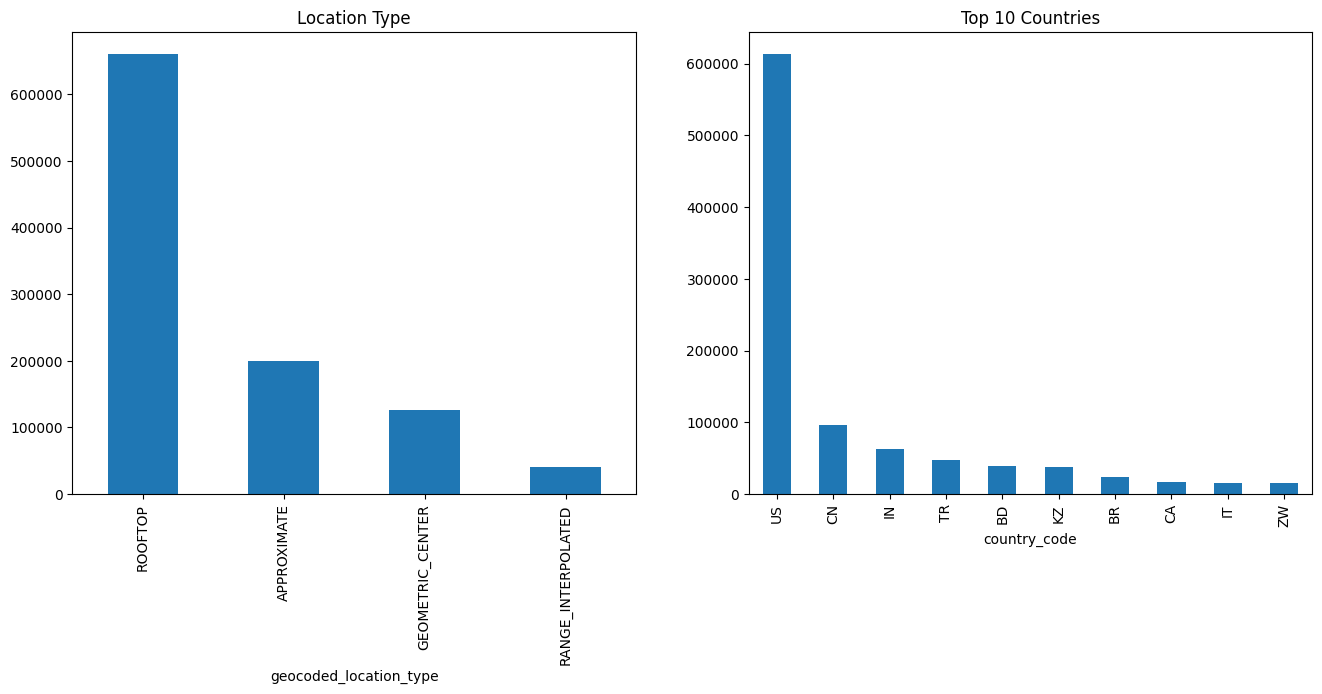

In [46]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
locs_df['geocoded_location_type'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Location Type')
locs_df['country_code'].value_counts().sort_values(ascending=False)[
    :10].plot(kind='bar', ax=ax[1])
ax[1].set_title('Top 10 Countries')
plt.show()

### 4. Profile completeness of the data

In [47]:
from splink.exploratory import completeness_chart
from splink import DuckDBAPI

completeness_chart(locs_df, db_api=DuckDBAPI())

alt.LayerChart(...)

### 5. Analyze data distribution

In [48]:
from splink.exploratory import profile_columns

profile_columns(locs_df, db_api=DuckDBAPI(), top_n=10, bottom_n=5)

alt.VConcatChart(...)

### 6. Plot found score distribution

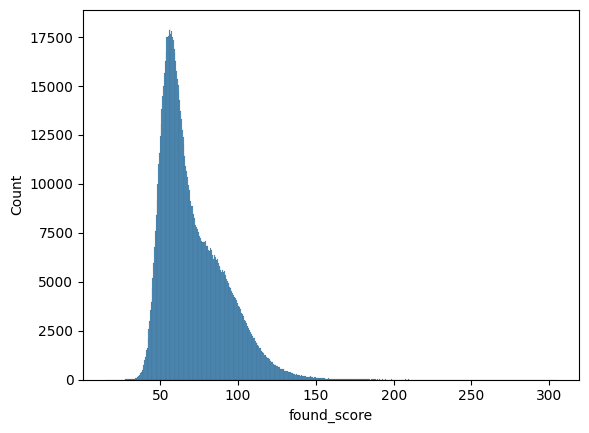

In [49]:
sns.histplot(data=locs_df, x="found_score")
plt.show()

## 7. Analyze potential blocking rules

In [50]:
from splink.blocking_analysis import count_comparisons_from_blocking_rule
from splink import block_on

In [51]:
db_api = DuckDBAPI()

main_rule = block_on("country_code")

counts = count_comparisons_from_blocking_rule(
    table_or_tables=locs_df,
    blocking_rule=main_rule,
    unique_id_column_name="os_id",
    link_type="dedupe_only",
    db_api=db_api
)

counts

Computation of number of comparisons post-filter conditions was skipped because the number of comparisons generated by your blocking rule exceeded max_rows_limit=1.00e+09.
It would be likely to be slow to compute.
If you still want to go ahead increase the value of max_rows_limit argument to above 3.964e+11.
Read more about the definitions here:
https://moj-analytical-services.github.io/splink/topic_guides/blocking/performance.html?h=filter+cond#filter-conditions


{'number_of_comparisons_generated_pre_filter_conditions': 396442501487,
 'number_of_comparisons_to_be_scored_post_filter_conditions': 'exceeded max_rows_limit, see warning',
 'filter_conditions_identified': '',
 'equi_join_conditions_identified': 'l."country_code" = r."country_code"',
 'link_type_join_condition': 'where l."os_id" < r."os_id"'}

## Model configuration

In [52]:
from splink import Linker, SettingsCreator
import splink.comparison_library as cl

### 1. Creating and configuring the model

In [53]:
settings = SettingsCreator(
    link_type="dedupe_only",
    comparisons=[
        cl.ExactMatch(
            col_name="geocoded_location_type",
        ),
        cl.JaroWinklerAtThresholds(
            col_name="name",
        ),
        cl.JaccardAtThresholds(
            col_name="address",
        ),
        cl.JaroWinklerAtThresholds(
            col_name="geocoded_address",
        ),
        cl.DistanceInKMAtThresholds(
            lat_col="lat",
            long_col="lng",
            km_thresholds=[0.005, 0.1, 0.152, 1.0, 5, 30]
        ),
    ],
    blocking_rules_to_generate_predictions=[
        block_on("country_code"),
    ],
    retain_intermediate_calculation_columns=True,
    unique_id_column_name="os_id",
    probability_two_random_records_match=0.05,
)

duck_db = DuckDBAPI()

linker = Linker(locs_df, settings, db_api=duck_db)

### 2. Estimating U probabilities

The `U` probabilities are calculated for every matching rule and essentially determine how often a particular matching scenario occurs between **non-matching** records.

In [54]:
linker.training.estimate_u_using_random_sampling(max_pairs=30e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - geocoded_location_type (no m values are trained).
    - name (no m values are trained).
    - address (no m values are trained).
    - geocoded_address (no m values are trained).
    - lat_lng (no m values are trained).


### 3. Estimating `M` probabilities

The `M` probabilities are also calculated for every matching rule, and they measure how often the scenario occurs among **matching** records.

In [55]:
training_session_result = linker.training.estimate_parameters_using_expectation_maximisation(
    block_on("geo_hash_4"),)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l."geo_hash_4" = r."geo_hash_4"

Parameter estimates will be made for the following comparison(s):
    - geocoded_location_type
    - name
    - address
    - geocoded_address
    - lat_lng

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 

Iteration 1: Largest change in params was -0.949 in the m_probability of name, level `Exact match on name`
Iteration 2: Largest change in params was 0.413 in the m_probability of address, level `All other comparisons`
Iteration 3: Largest change in params was 0.604 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.0273 in probability_two_random_records_match
Iteration 5: Largest change in params was 0.000107 in probability_two_random_records_match
Iteration 6: Largest change in params was 5.49e-05 in probability_two_random_records_match

EM converged aft

In [57]:
linker.misc.save_model_to_json(
    "./record_linkage_model_beta.json", overwrite=True
)

{'link_type': 'dedupe_only',
 'probability_two_random_records_match': 0.05,
 'retain_matching_columns': True,
 'retain_intermediate_calculation_columns': True,
 'additional_columns_to_retain': [],
 'sql_dialect': 'duckdb',
 'linker_uid': 'hh4wtzjf',
 'em_convergence': 0.0001,
 'max_iterations': 25,
 'bayes_factor_column_prefix': 'bf_',
 'term_frequency_adjustment_column_prefix': 'tf_',
 'comparison_vector_value_column_prefix': 'gamma_',
 'unique_id_column_name': 'os_id',
 'source_dataset_column_name': 'source_dataset',
 'blocking_rules_to_generate_predictions': [{'blocking_rule': 'l."country_code" = r."country_code"',
   'sql_dialect': 'duckdb'}],
 'comparisons': [{'output_column_name': 'geocoded_location_type',
   'comparison_levels': [{'sql_condition': '"geocoded_location_type_l" IS NULL OR "geocoded_location_type_r" IS NULL',
     'label_for_charts': 'geocoded_location_type is NULL',
     'fix_m_probability': False,
     'fix_u_probability': False,
     'is_null_level': True},
    {

In [58]:
linker.visualisations.match_weights_chart()

alt.VConcatChart(...)

In [59]:
linker.visualisations.m_u_parameters_chart()

alt.HConcatChart(...)